# 📊 Sailing Agent Model Comparison

This notebook loads all training results from the `results/` directory and facilitates comparison between different models and hyperparameters.

In [48]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import numpy as np

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Results Data

## 3. Robustness Analysis 🛡️

Évalue la robustesse des modèles sur **tous les scénarios** en calculant:
- **Moyenne** des scores
- **Écart-type** (pénalise la variabilité)
- **Score robuste** = Moyenne - 0.5 × Écart-type

In [49]:
## 3. Robustness Analysis 🛡️
# Load ALL scenarios for each model and calculate robust score\n
results_dir = '../results'
ALL_SCENARIOS = ['simple_static', 'static_headwind', 'training_1', 'training_2', 'training_3']

robustness_data = []

for filename in os.listdir(results_dir):
    if not filename.endswith('.json'):
        continue
    filepath = os.path.join(results_dir, filename)
    try:
        with open(filepath, 'r') as f:
            result = json.load(f)
        
        evaluation = result.get('evaluation', {})
        if not evaluation:
            continue
        
        # Collect scores for ALL scenarios
        scores = []
        for scenario in ALL_SCENARIOS:
            if scenario in evaluation:
                score = evaluation[scenario].get('custom_score', None)
                if score is not None:
                    scores.append(score)
        
        if len(scores) < 2:
            continue
        
        # Calculate statistics
        mean_score = np.mean(scores)
        std_score = np.std(scores, ddof=1)  # Sample std
        robust_score = mean_score - 0.5 * std_score
        
        robustness_data.append({
            'filename': filename,
            'agent': result.get('metadata', {}).get('agent', 'Unknown'),
            'num_scenarios': len(scores),
            'mean_score': mean_score,
            'std_score': std_score,
            'robust_score': robust_score,
            'min_score': min(scores),
            'max_score': max(scores)
        })
    except Exception as e:
        pass

# Create DataFrame
df_robust = pd.DataFrame(robustness_data)

# Sort by robust_score
df_robust =df_robust.sort_values('robust_score', ascending=False)
print(f'Robustness Analysis for {len(df_robust)} models\\n')
print('Formula: Robust Score = Mean - 0.5 * Std\\n')

# Display styled table\n
df_robust[['filename', 'agent', 'num_scenarios', 'mean_score', 'std_score', 'robust_score']].style \
    .background_gradient(subset=['mean_score'], cmap='RdYlGn') \
    .background_gradient(subset=['std_score'], cmap='RdYlGn_r') \
    .background_gradient(subset=['robust_score'], cmap='RdYlGn') \
    .format(precision=2)

Robustness Analysis for 32 models\n
Formula: Robust Score = Mean - 0.5 * Std\n


,filename,agent,num_scenarios,mean_score,std_score,robust_score
30,20260120_021827_vmg_agent_44_points.json,vmg_agent,5,43.69,18.61,34.38
28,20260120_033001_relative_agent.json,relative_agent,3,38.76,13.67,31.92
25,20260120_025617_vmg_agent.json,vmg_agent,5,22.53,23.04,11.01
23,20260120_024237_vmg_agent.json,vmg_agent,5,22.53,23.04,11.01
26,20260120_030028_vmg_agent.json,vmg_agent,5,21.74,22.07,10.71
27,20260120_030343_vmg_agent.json,vmg_agent,5,20.64,20.83,10.23
31,20260120_024827_vmg_agent_2_points.json,vmg_agent,5,22.17,25.17,9.59
16,20260120_014825_vmg_agent.json,vmg_agent,5,16.41,15.27,8.78
22,20260120_022914_vmg_agent.json,vmg_agent,5,16.27,15.48,8.53
11,20260120_011417_vmg_agent.json,vmg_agent,5,13.39,9.76,8.51


In [50]:
def load_results(results_dir="../results"):
    data = []
    
    if not os.path.exists(results_dir):
        print(f"Directory {results_dir} not found!")
        return pd.DataFrame()
    
    # Iterate over all JSON files
    for filename in os.listdir(results_dir):
        if filename.endswith(".json"):
            filepath = os.path.join(results_dir, filename)
            try:
                with open(filepath, 'r') as f:
                    result = json.load(f)
                
                # Flatten the structure
                entry = {
                    'filename': filename,
                    'timestamp': result.get('metadata', {}).get('timestamp', 'N/A'),
                    'agent': result.get('metadata', {}).get('agent', 'Unknown'),
                }
                
                # Add Evaluation Metrics (Overall)
                if 'evaluation' in result:
                    # Assumes training_1 is present, or takes limits
                    # Ideally we want overall averaged metrics if available
                    # Let's try to find the 'overall' like stats if they were saved, or take average of scenarios
                    
                    # Check if we have the structured overall stats from recent update
                    eval_data = result['evaluation']["static_headwind"]
                    
                    entry['success_rate'] = eval_data.get('success_rate', 0) * 100 if eval_data.get('success_rate', 0) <= 1.0 else eval_data.get('success_rate', 0)
                    entry['avg_reward'] = eval_data.get('mean_reward', 0)
                    entry['avg_steps'] = eval_data.get('mean_steps', 0)
                    entry['custom_score'] = eval_data.get('custom_score', 0)
                
                elif 'training' in result:
                    # Fallback to training metrics if eval not present
                    entry['success_rate'] = result['training'].get('final_success_rate', 0) * 100
                    entry['avg_reward'] = result['training'].get('avg_reward', 0)
                    entry['avg_steps'] = result['training'].get('avg_steps', 0)
                    entry['custom_score'] = 0 # Not calculated during training

                # Add Hyperparameters
                if 'hyperparameters' in result:
                    for k, v in result['hyperparameters'].items():
                        entry[f'hp_{k}'] = v
                
                data.append(entry)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    
    return pd.DataFrame(data)

df = load_results()
print(f"Loaded {len(df)} results.")
if not df.empty:
    # Sort by timestamp descending
    df = df.sort_values('timestamp', ascending=False)

# Display first few rows
df.head()

Error loading physic_wind_with_shaped_reward.json: 'static_headwind'
Error loading pw_sr_optimal_angle.json: 'static_headwind'
Error loading 20260120_001434_None.json: 'static_headwind'
Error loading 20260120_001714_vmg_agent.json: 'static_headwind'
Error loading 20260120_032729_relative_agent.json: 'static_headwind'
Error loading 20260120_033001_relative_agent.json: 'static_headwind'
Loaded 38 results.


,filename,timestamp,agent,success_rate,avg_reward,avg_steps,custom_score,hp_learning_rate,hp_discount_factor,hp_exploration_rate,hp_position_bins,hp_velocity_bins,hp_wind_bins,hp_wind_preview_steps,hp_grid_size,hp_q_init_high
34,20260120_030343_vmg_agent.json,20260120_030343,vmg_agent,31.0,68.731400,961.11,0.001978,0.2,0.99,0.3,8.0,5.0,8.0,3.0,32.0,10.0
33,20260120_030028_vmg_agent.json,20260120_030028,vmg_agent,32.0,21.092922,997.75,0.001413,0.2,0.99,0.3,10.0,5.0,8.0,3.0,32.0,1.0
8,20260120_151609_vmg_agent.json,20260120_151609,vmg_agent,55.0,168.608350,882.23,0.007755,0.15,0.99,0.05,10.0,5.0,8.0,3.0,32.0,1.0
32,20260120_025617_vmg_agent.json,20260120_025617,vmg_agent,64.0,93.291514,835.01,0.014505,0.2,0.99,0.05,10.0,5.0,8.0,3.0,32.0,10.0
37,20260120_024827_vmg_agent_2_points.json,20260120_024827,vmg_agent,48.0,30.273887,878.14,0.007052,0.2,0.99,0.3,10.0,5.0,8.0,3.0,32.0,10.0
31,20260120_024718_vmg_agent.json,20260120_024718,vmg_agent,31.0,12.623553,1000.00,0.001338,0.2,0.99,0.3,8.0,5.0,8.0,3.0,32.0,10.0


## 2. Leaderboard 🏆

In [51]:
if not df.empty:
    # Select relevant columns for leaderboard
    cols = ['filename', 'agent', 'success_rate', 'avg_reward', 'avg_steps', 'custom_score']
    # Add hyperparam cols if they exist
    hp_cols = [c for c in df.columns if c.startswith('hp_')]
    cols.extend(hp_cols)
    
    leaderboard = df[cols].sort_values('custom_score', ascending=False)

    
    # Styling
    def highlight_best(s):
        is_max = s == s.max()
        return ['background-color: lightgreen' if v else '' for v in is_max]
    
    display(leaderboard.style.background_gradient(subset=['custom_score', 'success_rate'], cmap='Greens')\
                             .background_gradient(subset=['avg_steps'], cmap='Reds')\
                             .format({'success_rate': '{:.1f}%', 'avg_reward': '{:.1f}', 'avg_steps': '{:.1f}', 'custom_score': '{:.2f}'}))
else:
    print("No data available.")

,filename,agent,success_rate,avg_reward,avg_steps,custom_score,hp_learning_rate,hp_discount_factor,hp_exploration_rate,hp_position_bins,hp_velocity_bins,hp_wind_bins,hp_wind_preview_steps,hp_grid_size,hp_q_init_high
36,20260120_021827_vmg_agent_44_points.json,vmg_agent,98.0%,234.5,124.0,28.19,0.150000,0.990000,0.050000,10.000000,5.000000,8.000000,3.000000,32.000000,10.000000
17,20260120_010617_vmg_agent.json,vmg_agent,99.0%,135.3,250.6,7.98,0.150000,0.990000,0.050000,10.000000,5.000000,8.000000,3.000000,32.000000,10.000000
18,20260120_011417_vmg_agent.json,vmg_agent,94.0%,150.3,266.2,6.47,0.150000,0.990000,0.050000,10.000000,5.000000,8.000000,3.000000,32.000000,10.000000
20,20260120_013048_vmg_agent.json,vmg_agent,82.0%,146.5,400.8,1.46,0.150000,0.990000,0.050000,10.000000,5.000000,8.000000,3.000000,32.000000,10.000000
19,20260120_012122_vmg_agent.json,vmg_agent,82.0%,146.5,400.8,1.46,0.150000,0.990000,0.050000,10.000000,5.000000,8.000000,3.000000,32.000000,10.000000
30,20260120_024237_vmg_agent.json,vmg_agent,64.0%,93.3,835.0,0.01,0.200000,0.990000,0.300000,10.000000,5.000000,8.000000,3.000000,32.000000,10.000000
32,20260120_025617_vmg_agent.json,vmg_agent,64.0%,93.3,835.0,0.01,0.200000,0.990000,0.300000,10.000000,5.000000,8.000000,3.000000,32.000000,10.000000
37,20260120_024827_vmg_agent_2_points.json,vmg_agent,48.0%,30.3,878.1,0.01,0.200000,0.990000,0.300000,10.000000,5.000000,8.000000,3.000000,32.000000,10.000000
26,20260120_020807_vmg_agent.json,vmg_agent,47.0%,13.9,889.5,0.01,0.150000,0.990000,0.050000,10.000000,5.000000,8.000000,3.000000,32.000000,10.000000
23,20260120_014825_vmg_agent.json,vmg_agent,43.0%,44.7,908.5,0.00,0.150000,0.990000,0.050000,10.000000,5.000000,8.000000,3.000000,32.000000,10.000000


## 3. Visualization: Efficiency vs Success

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


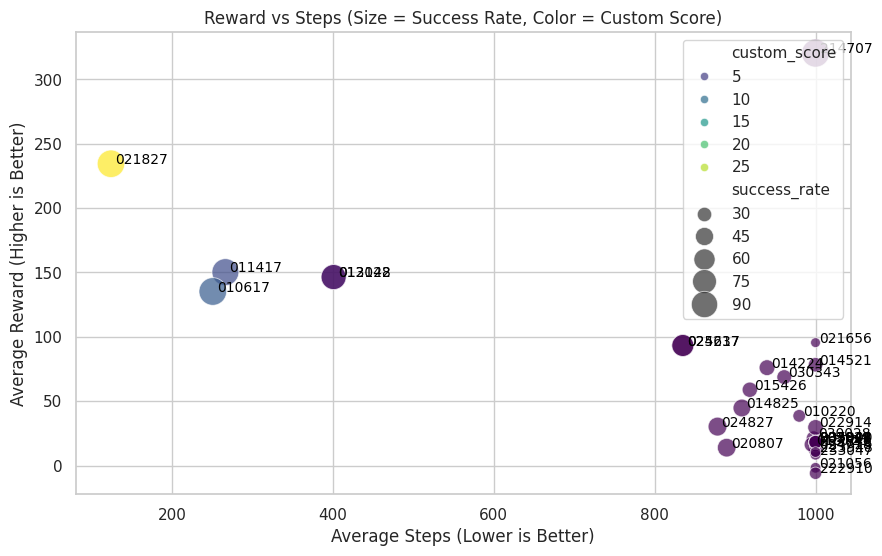

In [52]:
if not df.empty:
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(
        data=df, 
        x='avg_steps', 
        y='avg_reward', 
        size='success_rate', 
        hue='custom_score', 
        sizes=(50, 400), 
        palette='viridis',
        alpha=0.7
    )
    
    plt.title('Reward vs Steps (Size = Success Rate, Color = Custom Score)')
    plt.xlabel('Average Steps (Lower is Better)')
    plt.ylabel('Average Reward (Higher is Better)')
    
    # Add labels
    for line in range(0, df.shape[0]):
        plt.text(
            df.avg_steps.iloc[line]+5, 
            df.avg_reward.iloc[line], 
            df.timestamp.iloc[line][-6:], # Just show time
            horizontalalignment='left', 
            size='small', 
            color='black'
        )
        
    plt.show()
else:
    print("No data to plot.")

## 4. Hyperparameter Analysis
Select a hyperparameter to see its impact on the Custom Score.

In [53]:
import ipywidgets as widgets

if not df.empty and len(hp_cols) > 0:
    def plot_hp_impact(hp_name):
        plt.figure(figsize=(8, 5))
        # Check if numeric
        if pd.api.types.is_numeric_dtype(df[hp_name]):
            sns.regplot(data=df, x=hp_name, y='custom_score')
        else:
            sns.boxplot(data=df, x=hp_name, y='custom_score')
            sns.stripplot(data=df, x=hp_name, y='custom_score', color='black', alpha=0.5)
            
        plt.title(f'Impact of {hp_name} on Custom Score')
        plt.ylabel('Custom Score')
        plt.show()
    
    widgets.interact(plot_hp_impact, hp_name=sorted(hp_cols));
else:
    print("No hyperparameter data found.")

interactive(children=(Dropdown(description='hp_name', options=('hp_discount_factor', 'hp_exploration_rate', 'h…